In [1]:
import pandas as pd
import scipy.stats as stats

In [2]:
order_data = pd.read_csv('data/orders.csv')
browser_data = pd.read_csv('data/browsing.csv')

### Our Plan of Action

- Remove personal identifiers with the exception of the user ID, which is hashed so that if marketing team comes back with specific questions, we can try to help answer them
- If the user session came in with a tagged campaign, retain campaign information; otherwise leave blank
- Retain billing city and state, as this was specifically asked for by the marketing department to effectively answer questions for their campaigns
- Join order data and aggregate order quantity (number of orders) and order value (sum of quantities) per user
- Bound outliers that have exceptionally large or small amounts of customer value (if needed, you can create a written summary of these for marketing review)

In [3]:
order_data.head()

,order_number,user_id,email,street_address,city,state,num_items,total_price,timestamp
0,762,teresamooney,monique63@example.org,37785 Sean Hill,Davidstad,North Dakota,3,154,2022-03-31T14:40:10.181427
1,842,ularson,gewing@example.net,4710 Hodge Lodge Apt. 479,Denisestad,Wisconsin,9,62,2022-04-03T23:40:18.181427
2,904,bhurley,lori57@example.com,73746 Howard Parks Suite 958,Jacksontown,Iowa,9,90,2022-04-07T09:41:08.181427
3,500,schneiderstephanie,shawnedwards@example.org,0700 Joshua Unions Suite 255,Donaldmouth,Colorado,9,38,2022-04-08T15:41:21.181427
4,643,gibsonchristina,elliottchad@example.net,1599 Miranda Estates,Breannahaven,Pennsylvania,9,30,2022-04-09T22:42:10.181427


In [4]:
browser_data.head()

,order_number,inbound_uri,browser_agent,ip,timestamp
0,476,house-boy-power,Mozilla/5.0 (Linux; Android 4.1) AppleWebKit/5...,108.26.206.60,2022-03-31T14:50:10.339167
1,840,tend-performance,Opera/9.84.(Windows CE; ia-FR) Presto/2.9.176 ...,29.209.182.218,2022-04-01T23:50:57.339167
2,833,impact-result-ten,Mozilla/5.0 (Windows NT 5.0; nds-DE; rv:1.9.1....,9.50.100.243,2022-04-04T09:51:39.339167
3,518,sometimes-during,Mozilla/5.0 (compatible; MSIE 5.0; Windows 95;...,57.176.97.149,2022-04-07T10:52:40.339167
4,288,result-north,Mozilla/5.0 (Windows; U; Windows CE) AppleWebK...,65.25.200.138,2022-04-09T20:53:25.339167


### First we drop the unnecessary PII columns

In [5]:
browser_data = browser_data.drop(['browser_agent', 'ip'], axis=1)

In [6]:
order_data = order_data.drop(['email', 'street_address'], axis=1)

In [7]:
browser_and_orders = browser_data.merge(order_data, how='inner', on=['order_number'], suffixes=('__browser','__order'))

In [8]:
browser_and_orders.head()

,order_number,inbound_uri,timestamp__browser,user_id,city,state,num_items,total_price,timestamp__order
0,476,house-boy-power,2022-03-31T14:50:10.339167,mike27,Youngstad,New Mexico,7,174,2032-03-28T18:32:56.181427
1,476,house-boy-power,2022-03-31T14:50:10.339167,atkinsonscott,Port Ryan,Texas,6,126,2034-02-28T01:36:43.181427
2,476,house-boy-power,2022-03-31T14:50:10.339167,jefferyjohnson,New Richard,Minnesota,8,138,2035-10-14T09:10:52.181427
3,476,house-boy-power,2022-03-31T14:50:10.339167,jamesrivera,West Jesse,Tennessee,6,94,2045-08-11T06:45:31.181427
4,476,house-boy-power,2022-03-31T14:50:10.339167,bookerjack,South Johnland,Louisiana,9,182,2067-09-11T09:45:11.181427


In [9]:
summary_by_order = browser_and_orders.groupby('order_number').agg({'user_id':'first', 
                                                'city':'first', 
                                                'state':'first', 
                                                'num_items':'sum',
                                                'total_price': 'sum',
                                                'timestamp__order': 'first',
                                                'inbound_uri': 'first'})

In [10]:
summary_by_order.head()

,user_id,city,state,num_items,total_price,timestamp__order,inbound_uri
order_number,,,,,,,
0,egarcia,North Alexander,Arizona,648,12288,2034-08-02T13:15:37.181427,or-become-in
1,youngnathaniel,Port Tara,Kansas,1104,18120,2029-01-09T19:39:19.181427,identify-enter
2,brooke22,Caseview,Delaware,924,25872,2023-03-31T13:23:30.181427,course-cost-the
3,qcherry,Lake Gregorymouth,North Carolina,700,9060,2025-12-18T00:53:31.181427,buy-be-choice-their
4,codyjohnson,Austinfurt,Nevada,410,7280,2027-12-01T23:59:49.181427,court-represent


### Encrypting the User ID

In [11]:
summary_by_order.user_id.map(lambda x: len(x)).max()

20

In [12]:
import string, random

def genkey(length: int):
    """Generate key."""
    return "".join(random.choice(string.ascii_lowercase + 
                                 string.ascii_uppercase + 
                                 string.digits + 
                                 '[@_!#$%^&*()<>?/\|}{~:]') for _ in range(length))

def xor_strings(s, t):
    """xor two strings together."""
    if isinstance(s, str):
        # Text strings contain single characters
        return "".join(chr(ord(a) ^ ord(b)) for a, b in zip(s, t))
    else:
        # Bytes objects contain integer values in the range 0-255
        return bytes([a ^ b for a, b in zip(s, t)])

In [13]:
my_secret_key = genkey(20)

In [14]:
def xor_username(key, string):
    if len(string) < 20:
        string += ' ' * (20 - len(string))
    return xor_strings(string, key)

In [15]:
summary_by_order['e_user_id'] = summary_by_order.user_id.map(lambda x: xor_username(my_secret_key, x))

In [16]:
summary_by_order = summary_by_order.drop(['user_id'], axis=1)

In [17]:
xor_username(my_secret_key, summary_by_order['e_user_id'][1])

'youngnathaniel      '

### Key Safety

What happens if we change or lose the key? :/ 

In [18]:
backup = my_secret_key

In [19]:
my_secret_key = genkey(20)

In [20]:
xor_username(my_secret_key, summary_by_order['e_user_id'][1])

'LYYbw&\n\x10g_\x1cga\\q/}N\x1d6'

### Finding Bounds and Outliers

<AxesSubplot:>

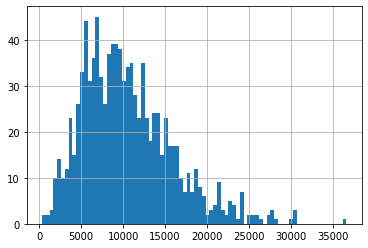

In [18]:
summary_by_order.total_price.hist(bins=80)

<AxesSubplot:>

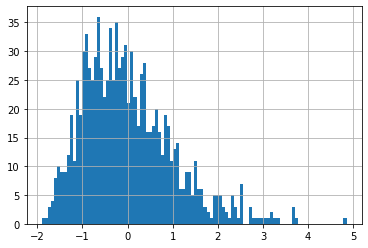

In [19]:
summary_by_order['z-score'] = stats.zscore(list(summary_by_order.total_price))

summary_by_order['z-score'].hist(bins=100)

In [20]:
summary_by_order[summary_by_order.total_price > 27000].count()

city                11
state               11
num_items           11
total_price         11
timestamp__order    11
inbound_uri         11
e_user_id           11
z-score             11
dtype: int64

In [21]:
summary_by_order[summary_by_order.total_price < 1500].count()

city                5
state               5
num_items           5
total_price         5
timestamp__order    5
inbound_uri         5
e_user_id           5
z-score             5
dtype: int64

In [22]:
def remove_order_outliers(total):
    if total > 27000 or total < 1500:
        # NOTE: we want to watch this over time if we rerun the report and make sure it is fitting.
        # We could also normalize the data and use Interquartile Range (IQR) or Z-Scores 
        return True
    return False

In [23]:
summary_by_order['remove'] = summary_by_order.total_price.map(remove_order_outliers)

In [24]:
summary_by_order.count()

city                1000
state               1000
num_items           1000
total_price         1000
timestamp__order    1000
inbound_uri         1000
e_user_id           1000
z-score             1000
remove              1000
dtype: int64

In [25]:
summary_by_order = summary_by_order[summary_by_order['remove'] == False]

In [32]:
summary_by_order = summary_by_order.drop(['remove'], axis=1)

### Getting started with Great Expectations

In [27]:
import great_expectations as ge
context = ge.get_context()

In [34]:
ge_df = ge.from_pandas(summary_by_order)

In [36]:
ge_df.expect_column_values_to_be_between('total_price', 1500, 27000)

{
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "success": true,
  "result": {
    "element_count": 984,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  }
}

In [37]:
ge_df.get_expectation_suite(discard_failed_expectations=False)


2022-05-11T10:27:20+0200 - INFO - 	1 expectation(s) included in expectation_suite. result_format settings filtered.


{
  "expectation_suite_name": "default",
  "ge_cloud_id": null,
  "meta": {
    "great_expectations_version": "0.15.1"
  },
  "data_asset_type": "Dataset",
  "expectations": [
    {
      "meta": {},
      "kwargs": {
        "column": "total_price",
        "min_value": 1500,
        "max_value": 27000
      },
      "expectation_type": "expect_column_values_to_be_between"
    }
  ]
}

In [38]:
import json
with open("order_summary_for_sharing_expecation_file.json", "w") as my_file:    
    my_file.write(        
        json.dumps(ge_df.get_expectation_suite().to_json_dict())
    )

2022-05-11T10:28:43+0200 - INFO - 	1 expectation(s) included in expectation_suite. result_format settings filtered.


In [29]:
summary_by_order.to_csv('data/order_summary_for_sharing.csv')